In [1]:
%matplotlib notebook

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
from scipy.spatial import KDTree
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
import os
import rasterio
from osgeo import gdal, gdal_array, osr
import pyproj
import statistics

In [2]:
''' Corners of the box of interest '''
location = 0
thing = 3 # 0: EVC, 1: EVT, 2: EVH, 3: ECV_2014, 4: ECT_2014, 5: EVH_2014

centers  = [[-153.65, 66.70], # Alatna (2, 3572)
            [-155.69, 66.01], # Huslia (2, 3612)
            [-157.01, 66.96], # (2, 3548)
            [-157.82, 65.81], # (2, 3630)
            [-158.34, 65.23], # (2, 3674)
            [-153.05, 67.12], # (2, 3537)
            [-152.30, 67.12], # (2, 3539)
            [-150.92, 66.71], # (2, 3568)
            [-146.44, 66.96], # (2, 3550) 
            [-153.26, 64.53]] # (2, 3728)

min_lon = centers[location][0] - .65
max_lon = centers[location][0] + .65
min_lat = centers[location][1] - .25
max_lat = centers[location][1] + .25

box_lon = np.array([min_lon, max_lon, max_lon, min_lon, min_lon])
box_lat = np.array([min_lat, min_lat, max_lat, max_lat, min_lat])

print(max(box_lon), min(box_lon), min_lon, max_lon, min_lat, max_lat)

-153.0 -154.3 -154.3 -153.0 66.45 66.95


In [3]:
''' Get necessary files '''
filenames = ["/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVC/LF2016_EVC_200_AK/Tif/LA16_EVC_200.tif",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVT/LF2016_EVT_200_AK/Tif/LA16_EVT_200.tif",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVH/LF2016_EVH_200_AK/Tif/LA16_EVH_200.tif",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVC_2014/AK_140_EVC/Tif/ak_140evc.tif",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVT_2014/AK_140_EVT/Tif/ak_140evt.tif",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVH_2014/AK_140_EVH/Tif/ak_140evh.tif"]

key_path  = ["/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVC/LF2016_EVC_200_AK/CSV_Data/LF16_EVC_200.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVT/LF2016_EVT_200_AK/CSV_Data/LF16_EVT_200.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVH/LF2016_EVH_200_AK/CSV_Data/LF16_EVH_200.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVC_2014/AK_140_EVC/CSV_Data/ak_140evc.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVT_2014/AK_140_EVT/CSV_Data/ak_140evt.csv",
            "/Users/joshuamiller/Documents/SULI 2023/Data/LANDFIRE_EVH_2014/AK_140_EVH/CSV_Data/ak_140evh.csv"]

filename = filenames[thing]
key_df = pd.read_csv(key_path[thing])

<IPython.core.display.Javascript object>


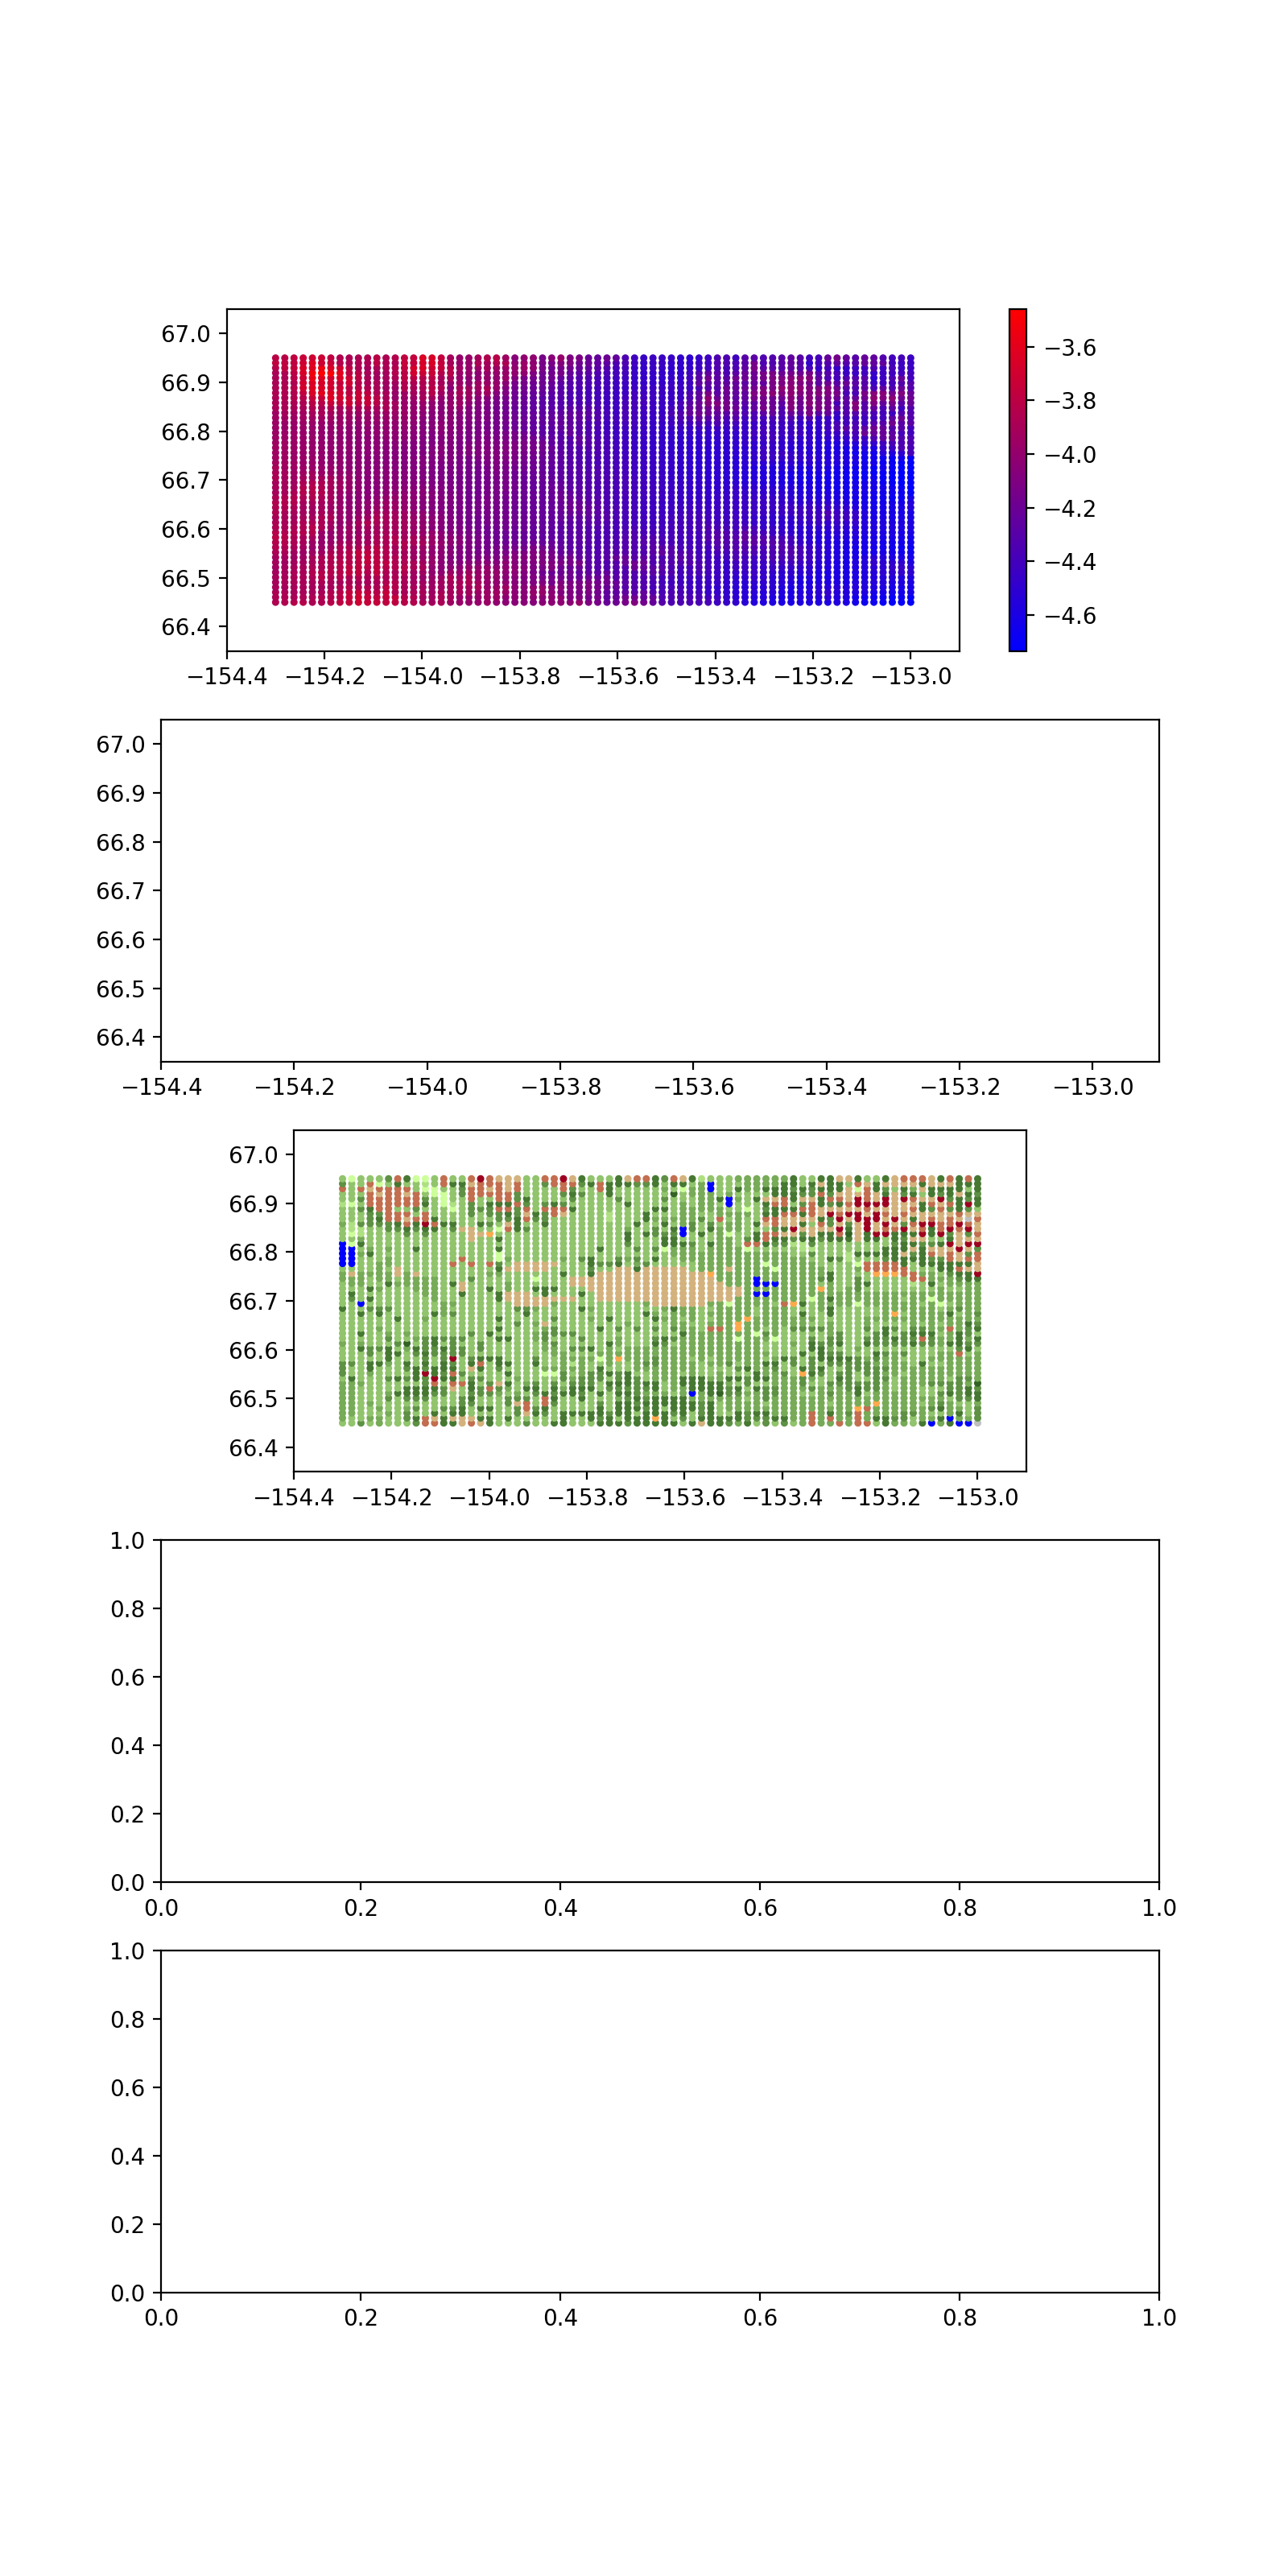

(66.35000000000001, 67.05)

In [4]:
fig, ax = plt.subplots(5, figsize=(8, 16))
ax[0].set_xlim(min_lon - .1, max_lon + .1)
ax[0].set_ylim(min_lat - .1, max_lat + .1)
ax[1].set_xlim(min_lon - .1, max_lon + .1)
ax[1].set_ylim(min_lat - .1, max_lat + .1)
ax[2].set_xlim(min_lon - .1, max_lon + .1)
ax[2].set_ylim(min_lat - .1, max_lat + .1)

## Get tmax data

In [7]:
tmax_files = ["/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/Temp/tmax_Alatna_2016_1_1-2016_12_31_krig_grid.nc",
              "/Users/joshuamiller/Documents/SULI 2023/Data/Huslia/Temp/tmax_Huslia_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Temp/tmax_Loc1_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Temp/tmax_Loc2_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Temp/tmax_Loc3_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Temp/tmax_Loc4_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Temp/tmax_Loc5_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Temp/tmax_Loc6_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Temp/tmax_Loc7_2016_1_1-2016_12_31_krig_grid.nc",
             "/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Temp/tmax_Loc8_2016_1_1-2016_12_31_krig_grid.nc"]

In [8]:
f = nc.Dataset(tmax_files[location], "r")
print(f.dimensions.keys())

# Print the variables in the file
print(f.variables.keys())

lat_tmax = f.variables["lat"] # Pointer to variable
lat_tmax = np.array(lat_tmax[:]) # : Extracts the numbers

lon_tmax = f.variables["lon"]
lon_tmax = np.array(lon_tmax[:])

time_tmax = f.variables["time"]
time_tmax = np.array(time_tmax[:])

tmax = f.variables["tmax"]
tmax = np.array(tmax[:])
f.close()

dict_keys(['time', 'x', 'y'])
dict_keys(['lat', 'lon', 'time', 'tmax'])


In [9]:
print(np.shape(lat_tmax), np.shape(lon_tmax), min(lat_tmax.ravel()), max(lat_tmax.ravel()), min(lon_tmax.ravel()), max(lon_tmax.ravel()), np.shape(tmax))

(70, 50) (70, 50) 66.45 66.95 -154.3 -153.0 (365, 70, 50)


In [10]:
''' Get points for the temp plot '''
points_tmax = [Point(xy) for xy in zip(lon_tmax.ravel(), lat_tmax.ravel())]
points_tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax)

In [11]:
date = 300

tmax_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=tmax[date, :].ravel())

print(tmax_gdf.head())

                      geometry   data
0  POINT (-154.30000 66.45000) -3.860
1  POINT (-154.30000 66.46021) -3.875
2  POINT (-154.30000 66.47041) -3.875
3  POINT (-154.30000 66.48061) -3.900
4  POINT (-154.30000 66.49081) -3.910


In [12]:
norm_tmax = Normalize(vmin=min(tmax_gdf['data']), vmax=max(tmax_gdf['data']))
cmap_tmax = LinearSegmentedColormap.from_list('custom', ['blue', 'red'], N=200) # Higher N=more smooth

In [13]:
tmax_gdf.plot(ax=ax[0], column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=5, alpha=1, legend=True)

plt.draw()

## Get lat/lon, pixel coords, and pixel values at the coords in tmax

In [14]:
''' Load data '''
raster = rasterio.open(filename)
band = raster.read(1) # Only one band made of integers

dataset = gdal.Open(filename)

print(raster.crs)

EPSG:3338


In [15]:
in_sr = osr.SpatialReference()
in_sr.ImportFromEPSG(3338)

# Define the output coordinate system (latitude-longitude in this case)
out_sr = osr.SpatialReference()
out_sr.ImportFromEPSG(4326)

# Create the transformation object
transformer = osr.CoordinateTransformation(in_sr, out_sr)
# Get the geographic transform for the image
transform = dataset.GetGeoTransform() # from GDAL

print("rasterio.transform =", raster.transform, raster.bounds, raster.crs, raster.width, raster.height)

rasterio.transform = | 30.00, 0.00,-2175075.00|
| 0.00,-30.00, 2383755.00|
| 0.00, 0.00, 1.00| BoundingBox(left=-2175075.0, bottom=404475.0, right=1493055.0, top=2383755.0) EPSG:3338 122271 65976


In [16]:
''' Indentify pixels which are near the area of interest '''
lon_in_bounds = []
lat_in_bounds = []
val_in_bounds = []

x_pix = 0
while (x_pix <= raster.height):
    x_pix_inc = 500
    y_pix = 0
    while (y_pix <= raster.width):
        y_pix_inc = 500
        
        ''' Pixels -> meters '''
        x_m = transform[0] + y_pix * transform[1] + x_pix * transform[2]
        y_m = transform[3] + y_pix * transform[4] + x_pix * transform[5]
        
        ''' Meters -> lat/lon '''
        lat, lon, _ = transformer.TransformPoint(x_m, y_m)
        #print("x_pix =", x_pix, ", y_pix =", y_pix, ", lon =", lon, ", lat =", lat)
        ''' Slow down a little bit '''
        if ((lat > min_lat - 1) and (lat < max_lat + 1) and (lon > min_lon - 1) and (lon < max_lon + 1)):
            x_pix_inc = 10
            y_pix_inc = 10
            
        ''' A bit more '''
        if ((lat > min_lat - .5) and (lat < max_lat + .5) and (lon > min_lon - .1) and (lon < max_lon + .1)):
            x_pix_inc = 2
            y_pix_inc = 2
            
        ''' Slow all the way down to get all da points '''
        if ((lat > min_lat - .07) and (lat < max_lat + .2) and (lon > min_lon - .01) and (lon < max_lon + .01)):
            x_pix_inc = 1
            y_pix_inc = 1
            
            lon_in_bounds.append(lon)
            lat_in_bounds.append(lat)
            val_in_bounds.append(band[x_pix][y_pix])
            
            print("x_pix =", x_pix, ", y_pix =", y_pix, ", lon =", lon, ", lat =", lat, ", val =", band[x_pix][y_pix])
            
        y_pix += y_pix_inc
    x_pix += x_pix_inc

x_pix = 15780 , y_pix = 73376 , lon = -153.39860098189206 , lat = 67.1499976853351 , val = 103
x_pix = 15780 , y_pix = 73377 , lon = -153.3979125261584 , lat = 67.14999523544522 , val = 105
x_pix = 15780 , y_pix = 73378 , lon = -153.39722407055413 , lat = 67.14999278275242 , val = 106
x_pix = 15780 , y_pix = 73379 , lon = -153.39653561507944 , lat = 67.14999032725682 , val = 105
x_pix = 15780 , y_pix = 73380 , lon = -153.39584715973447 , lat = 67.14998786895849 , val = 103
x_pix = 15780 , y_pix = 73381 , lon = -153.39515870451933 , lat = 67.14998540785716 , val = 105
x_pix = 15780 , y_pix = 73382 , lon = -153.3944702494342 , lat = 67.14998294395306 , val = 105
x_pix = 15780 , y_pix = 73383 , lon = -153.39378179447922 , lat = 67.14998047724615 , val = 105
x_pix = 15780 , y_pix = 73384 , lon = -153.39309333965454 , lat = 67.14997800773642 , val = 105
x_pix = 15780 , y_pix = 73385 , lon = -153.39240488496029 , lat = 67.14997553542383 , val = 105
x_pix = 15780 , y_pix = 73386 , lon = -153.

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



-153.03882288732382 , lat = 66.80507968481344 , val = 162
x_pix = 17050 , y_pix = 73918 , lon = -153.0381434650902 , lat = 66.80507577402538 , val = 162
x_pix = 17050 , y_pix = 73919 , lon = -153.03746404305792 , lat = 66.80507186047407 , val = 163
x_pix = 17050 , y_pix = 73920 , lon = -153.03678462122716 , lat = 66.80506794415972 , val = 106
x_pix = 17050 , y_pix = 73921 , lon = -153.03610519959804 , lat = 66.80506402508209 , val = 161
x_pix = 17050 , y_pix = 73922 , lon = -153.03542577817072 , lat = 66.80506010324126 , val = 161
x_pix = 17050 , y_pix = 73923 , lon = -153.0347463569453 , lat = 66.80505617863733 , val = 103
x_pix = 17050 , y_pix = 73924 , lon = -153.03406693592194 , lat = 66.80505225127013 , val = 161
x_pix = 17050 , y_pix = 73925 , lon = -153.0333875151008 , lat = 66.80504832113976 , val = 161
x_pix = 17050 , y_pix = 73926 , lon = -153.03270809448205 , lat = 66.8050443882463 , val = 106
x_pix = 17050 , y_pix = 73927 , lon = -153.03202867406577 , lat = 66.8050404525896

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



, lat = 66.46360401908255 , val = 106
x_pix = 18320 , y_pix = 73493 , lon = -153.33554855200717 , lat = 66.4636013202424 , val = 104
x_pix = 18320 , y_pix = 73494 , lon = -153.334877772563 , lat = 66.46359861867643 , val = 104
x_pix = 18320 , y_pix = 73495 , lon = -153.33420699325453 , lat = 66.46359591438471 , val = 161
x_pix = 18320 , y_pix = 73496 , lon = -153.3335362140819 , lat = 66.46359320736718 , val = 162
x_pix = 18320 , y_pix = 73497 , lon = -153.33286543504528 , lat = 66.46359049762384 , val = 162
x_pix = 18320 , y_pix = 73498 , lon = -153.33219465614476 , lat = 66.46358778515462 , val = 163
x_pix = 18320 , y_pix = 73499 , lon = -153.33152387738053 , lat = 66.46358506995962 , val = 103
x_pix = 18320 , y_pix = 73500 , lon = -153.33085309875267 , lat = 66.46358235203894 , val = 104
x_pix = 18320 , y_pix = 73501 , lon = -153.33018232026137 , lat = 66.46357963139229 , val = 104
x_pix = 18320 , y_pix = 73502 , lon = -153.32951154190673 , lat = 66.46357690801993 , val = 104
x_pix 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
print(min(lon_in_bounds), max(lon_in_bounds), min(lat_in_bounds), max(lat_in_bounds))
print('----')
print(min_lon, max_lon, min_lat, max_lat)

-154.30999697310108 -152.99000029331188 66.38000262136272 67.1499976853351
----
-154.3 -153.0 66.45 66.95


In [18]:
''' Get corresponding rbg values from the integer values in the tif '''
R = ['RED', 'red']
G = ['GREEN', 'green']
B = ['BLUE', 'blue']

r = R[int(thing / 3)]
g = G[int(thing / 3)]
b = B[int(thing / 3)]

key_dict = {}
for i in range(key_df.shape[0]):
    key_dict[key_df.loc[i, "VALUE"]] = np.array([key_df.loc[i, r], key_df.loc[i, g], key_df.loc[i, b]])
#print(key_dict)

## Plot pixel map of box of interest

In [19]:
image_rgb = np.empty((len(val_in_bounds), 3), float)

In [20]:
for i in range(np.shape(image_rgb)[0]):
    for k in range(3):
        image_rgb[i][k] = key_dict[val_in_bounds[i]][k]  

In [21]:
#ax[1].scatter(x=lon_in_bounds, y=lat_in_bounds, c=image_rgb, s=.1)

## Krig this subset to tmax grid

In [22]:
lon_in_bounds = np.asarray(lon_in_bounds)
lat_in_bounds = np.asarray(lat_in_bounds)
val_in_bounds = np.asarray(val_in_bounds)

new_evc = np.empty((np.shape(tmax)[1], np.shape(tmax)[2]), dtype=float)

In [23]:
''' Create tree '''
print(np.array([lon_in_bounds, lat_in_bounds]).T.reshape(-1,2))

tree = KDTree(np.array([lon_in_bounds, lat_in_bounds]).T.reshape(-1,2))

[[-153.39860098   67.14999769]
 [-153.39791253   67.14999524]
 [-153.39722407   67.14999278]
 ...
 [-153.35233373   66.38000789]
 [-153.35166505   66.38000526]
 [-153.35099636   66.38000262]]


In [24]:
''' Obtain the ## nearest pixels, set new value to the color of the majority '''
for i in range(np.shape(tmax)[1]):
    for j in range(np.shape(tmax)[2]):
        ''' Get closest neighbors to desired point in tmax '''
        point = np.array([lon_tmax[i][j], lat_tmax[i][j]])

        dis, idx = tree.query(point, k = 50) 
    
        lon_krig = lon_in_bounds[idx]
        lat_krig = lat_in_bounds[idx]
        val_krig = val_in_bounds[idx]
    
        print("---------------", statistics.mode(val_krig), "------------------")
        #print("i =", i, ", idx =", idx, ", val =", val_krig, ", point =", point, " lon =", lon_krig, ", lat =", lat_krig)
        new_evc[i][j] = statistics.mode(val_krig)

--------------- 103 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 103 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 104 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 106 ------------------
--------------- 103 ------------------
--------------- 103 -----

--------------- 162 ------------------
--------------- 161 ------------------
--------------- 106 ------------------
--------------- 106 ------------------
--------------- 161 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 105 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 104 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 105 ------------------
--------------- 106 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 ------------------
--------------- 103 -----

In [25]:
new_evc_gdf = gpd.GeoDataFrame(geometry=points_tmax).assign(data=new_evc.ravel())

In [26]:
print(new_evc_gdf.head())

                      geometry   data
0  POINT (-154.30000 66.45000)  103.0
1  POINT (-154.30000 66.46021)  104.0
2  POINT (-154.30000 66.47041)  104.0
3  POINT (-154.30000 66.48061)  104.0
4  POINT (-154.30000 66.49081)  104.0


In [27]:
new_evc_gdf.plot(ax=ax[2], color=[key_dict[rgb] for rgb in new_evc_gdf['data']], markersize=5)

plt.draw()

## Save gridded lat, lon and pixel values as an csv file

In [28]:
''' Create an nc file of the new_tmax data '''
col_names = ['EVC_2016', 'EVT_2016', 'EVH_2016', 'EVC_2014', 'EVT_2014', 'EVH_2014']

df = pd.DataFrame({'lat': lat_tmax.ravel(), 'lon': lon_tmax.ravel(), col_names[thing]: new_evc.ravel()})

path = ['/Users/joshuamiller/Documents/SULI 2023/Data/Alatna/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Huslia/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc1/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc2/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc3/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc4/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc5/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc6/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc7/Land_Fire/',
       '/Users/joshuamiller/Documents/SULI 2023/Data/Loc8/Land_Fire/']
loc_names = ['Alatna', 'Huslia', 'Loc1', 'Loc2', 'Loc3', 'Loc4', 'Loc5', 'Loc6', 'Loc7', 'Loc8']

fig.savefig(os.path.join(path[location], col_names[thing]+'_'+loc_names[location]+'_krig_grid.pdf'),
                         bbox_inches = 'tight', pad_inches = 0)
#df.to_csv(os.path.join(path[location], col_names[thing]+'_'+loc_names[location]+'_krig_grid.csv'))

In [29]:
plt.savefig('/Users/joshuamiller/Documents/SULI 2023/Figures/'+
            col_names[thing]+'_'+loc_names[location]+'_krig_grid.pdf',
            bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


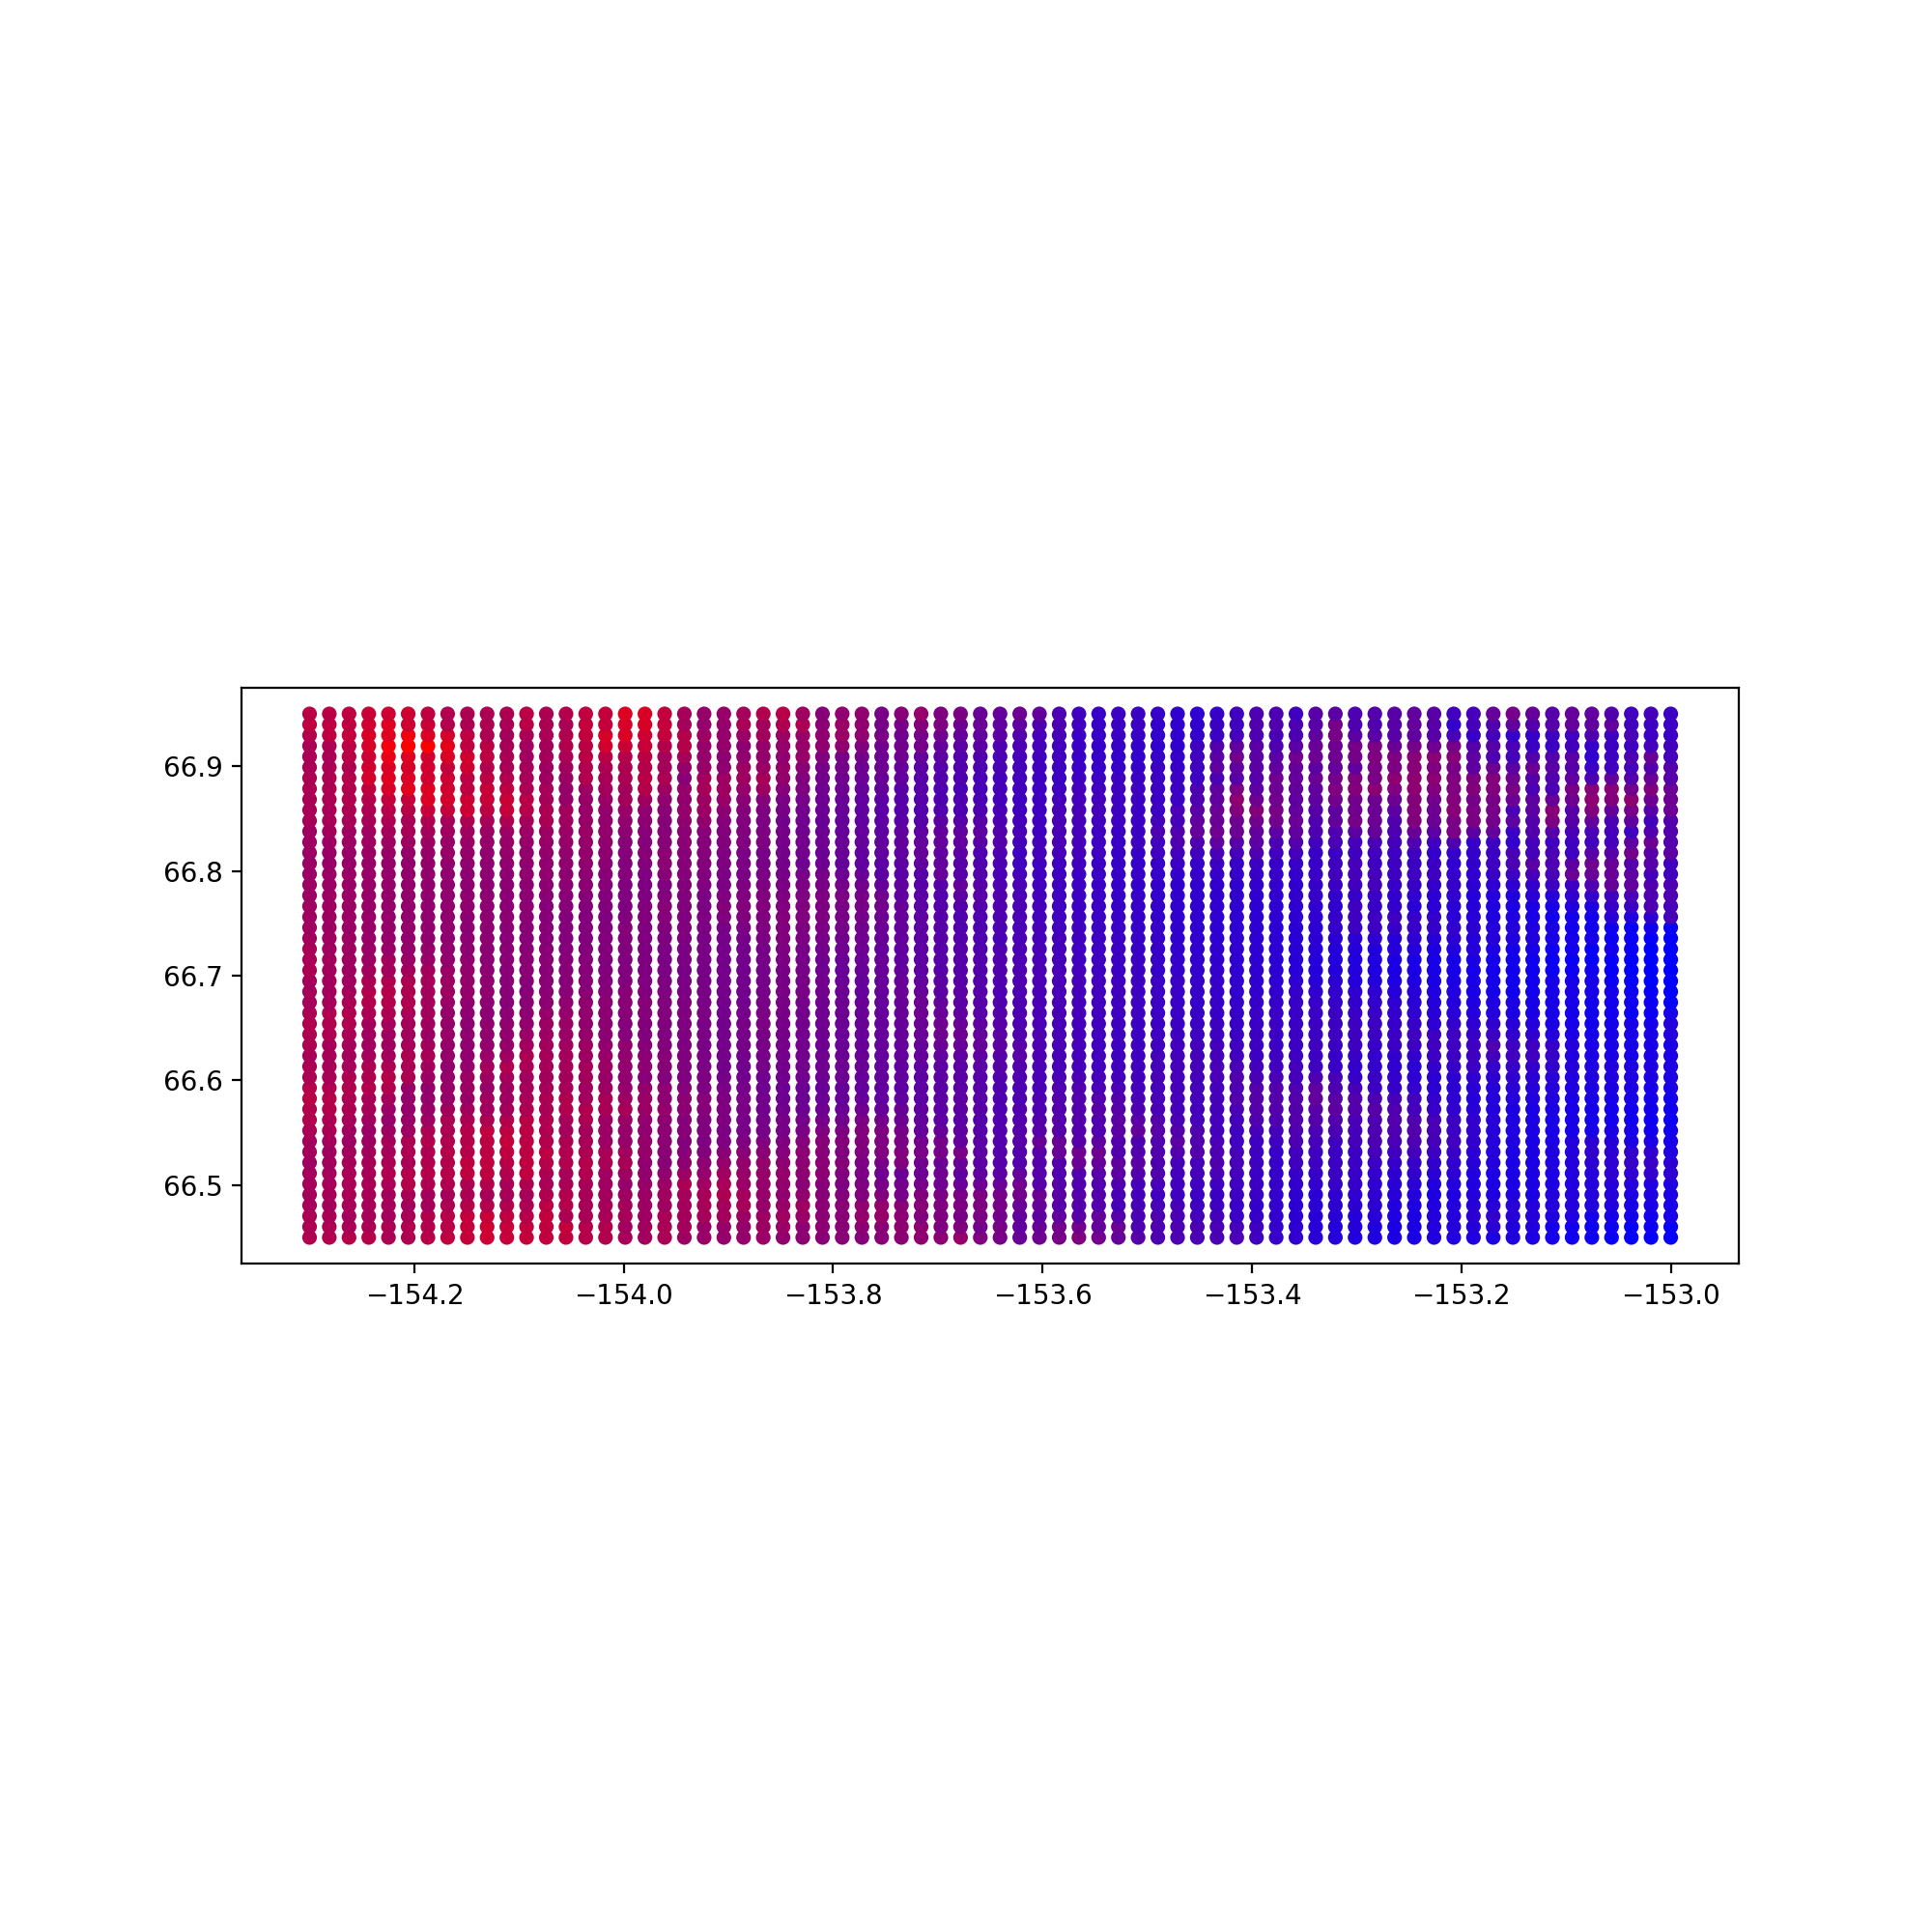

In [33]:
fig_temp, ax_temp = plt.subplots(figsize=(10, 10))

tmax_gdf.plot(ax=ax_temp, column='data', cmap=cmap_tmax, norm=norm_tmax, markersize=20, alpha=1)
plt.draw()

plt.savefig('/Users/joshuamiller/Documents/SULI 2023/Figures/'+
            'tmax_'+loc_names[location]+'_krig_grid.pdf',
            bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


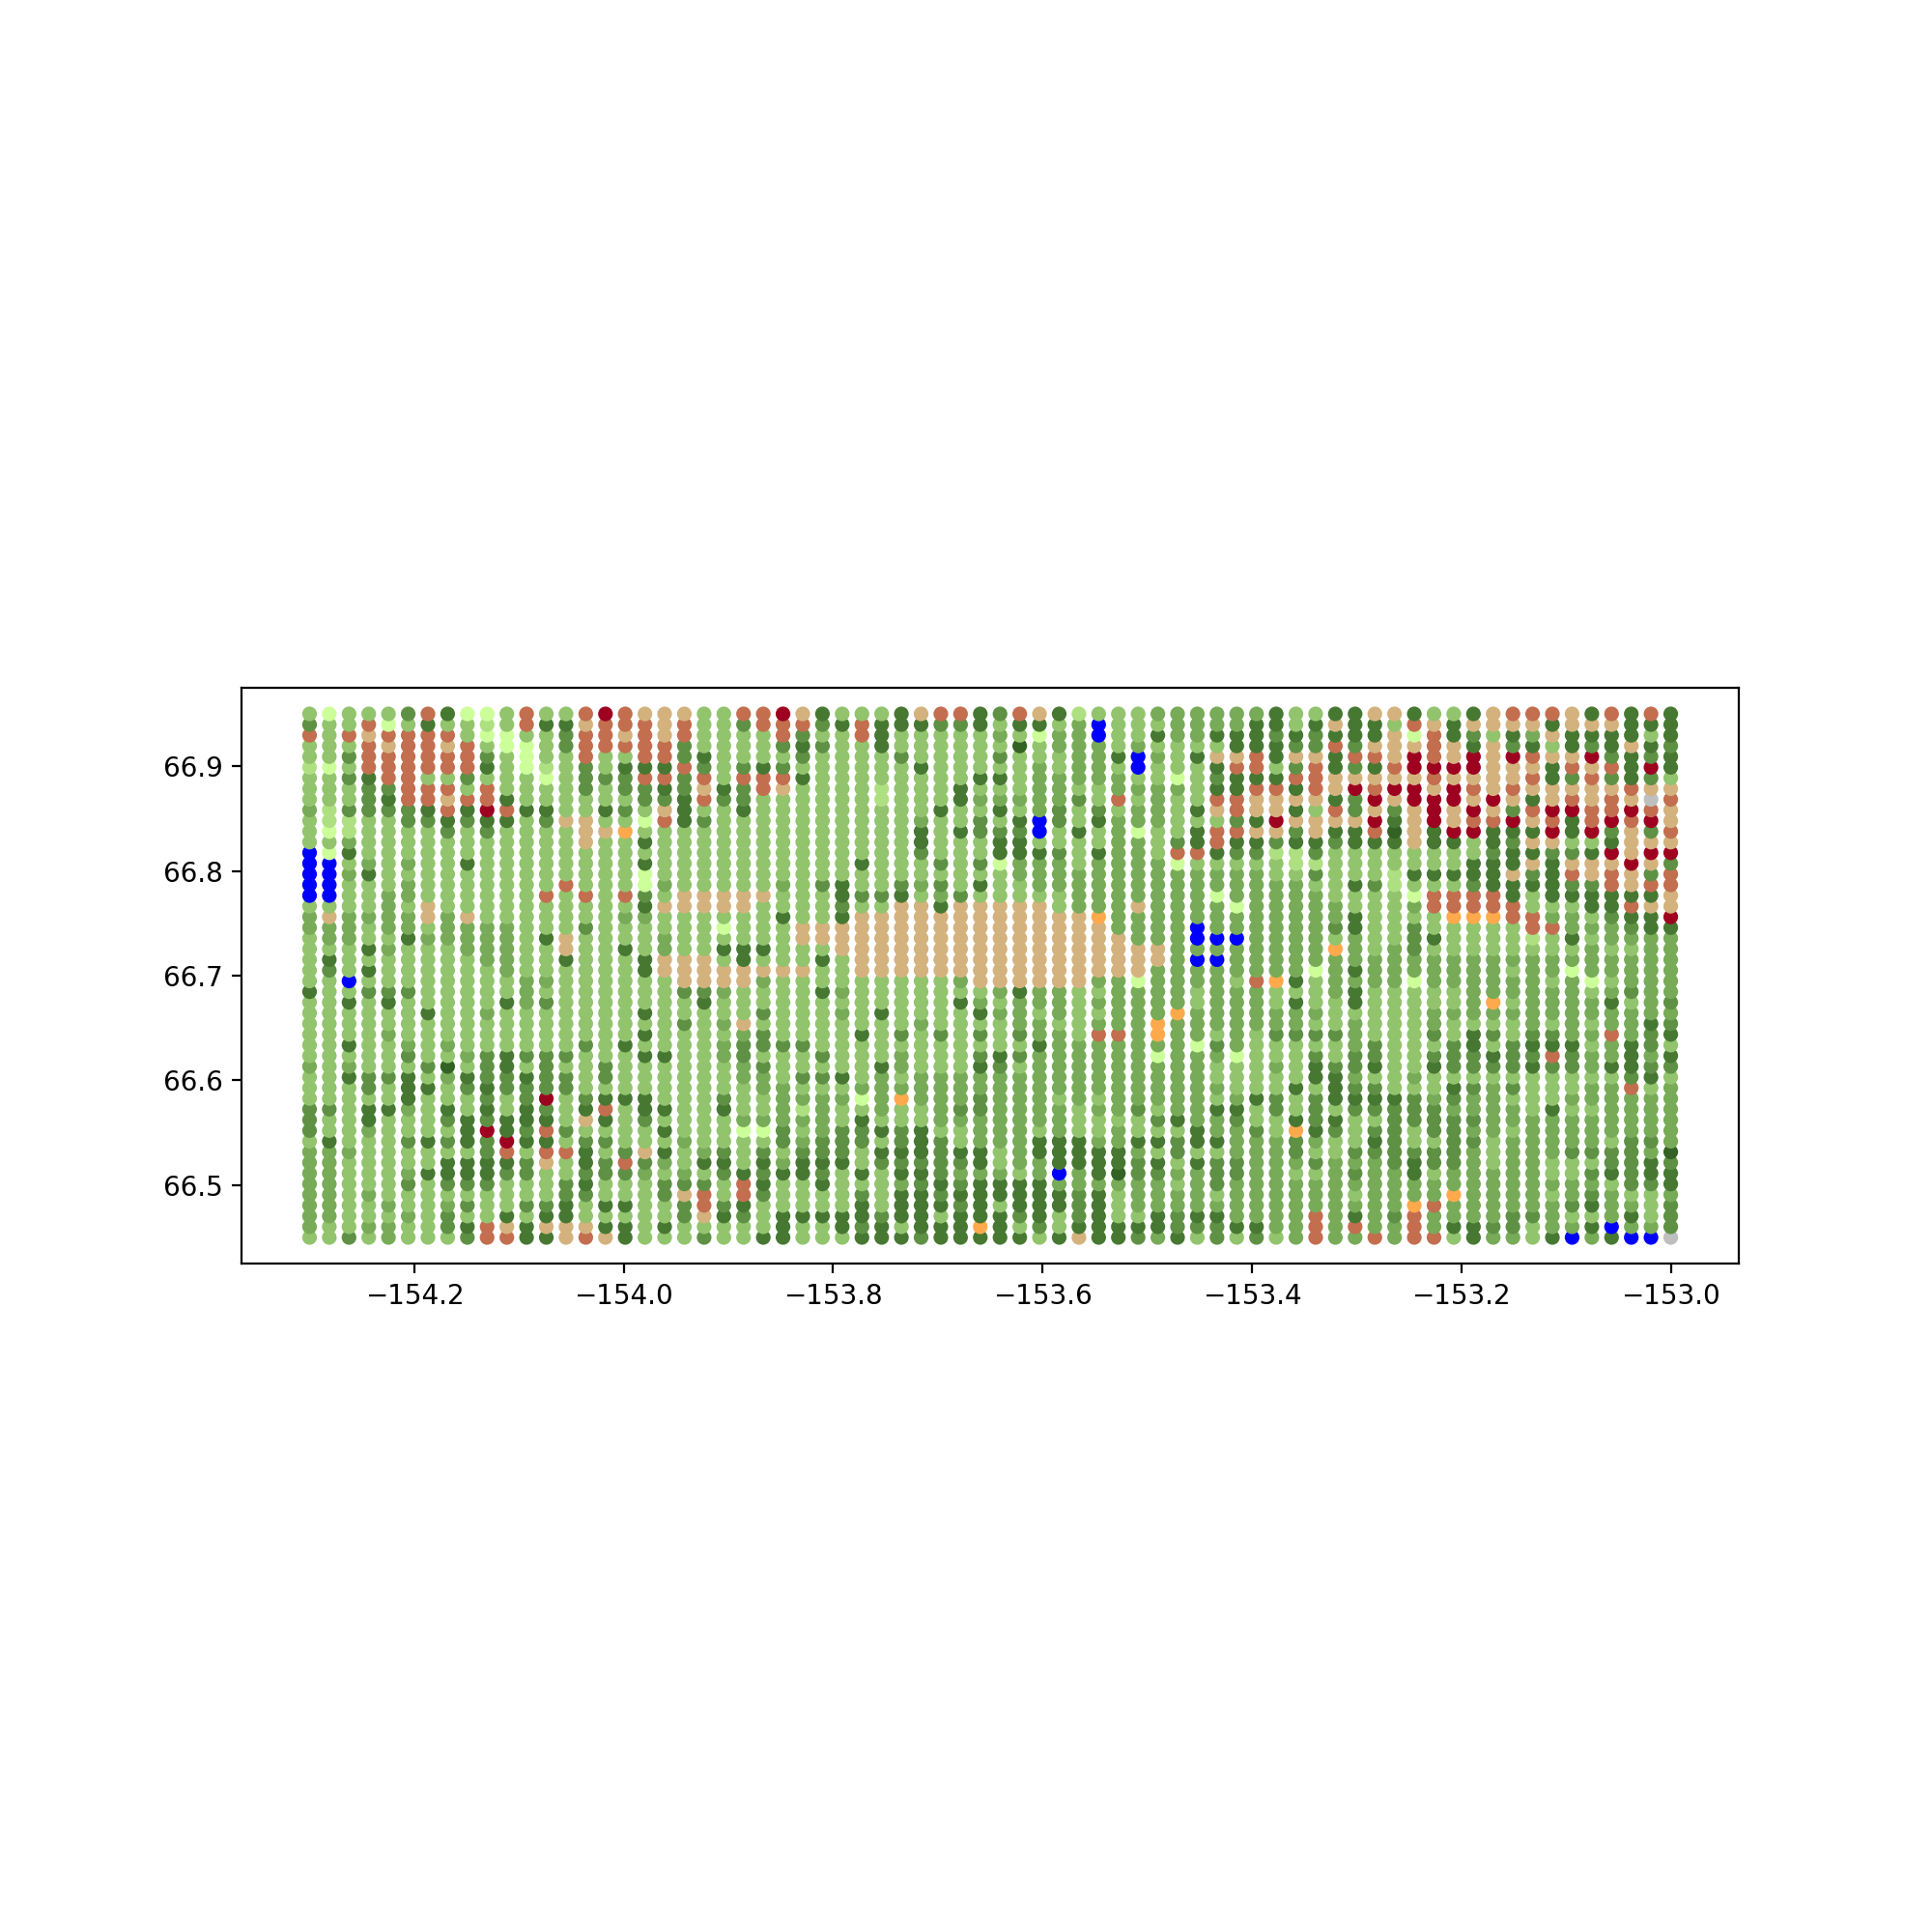

In [34]:
fig_evc, ax_evc = plt.subplots(figsize=(10, 10))

new_evc_gdf.plot(ax=ax_evc, color=[key_dict[rgb] for rgb in new_evc_gdf['data']], markersize=20)
plt.draw()

plt.savefig('/Users/joshuamiller/Documents/SULI 2023/Figures/'+
            col_names[thing]+'_'+loc_names[location]+'_krig_grid.pdf',
            bbox_inches = 'tight', pad_inches = 0)